In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

import torch
torch.set_default_dtype(torch.float64)

## Load behavioral data

In [2]:
os.chdir(cwd + '/pilot')
responses = np.load('responses.npy')

mask_all = torch.from_numpy((~np.isnan(responses)).astype(np.uint8))
responses_all = torch.from_numpy(np.nan_to_num(responses).astype(np.long))

offers_all = torch.from_numpy(np.load('offers.npy')).long()
outcomes = torch.from_numpy(np.load('outcomes.npy')).double()
outcomes[outcomes < 2] = (outcomes[outcomes < 2] + 1)/2
outcomes[torch.isnan(outcomes)] = 0.
outcomes_all = outcomes.long()

In [3]:
# split participants on groups and exclude non-explorers

non_expl = torch.sum(torch.squeeze(responses_all == 2), 0) < 20

mask_c1 = mask_all[..., :15][..., ~non_expl[:15]]
mask_c2 = mask_all[..., 15:][..., ~non_expl[15:]]

responses_c1 = responses_all[..., :15][..., ~non_expl[:15]]
responses_c2 = responses_all[..., 15:][..., ~non_expl[15:]]


offers_c1 = offers_all[..., :15][..., ~non_expl[:15]]
offers_c2 = offers_all[..., 15:][..., ~non_expl[15:]]


outcomes_c1 = outcomes_all[..., :15][..., ~non_expl[:15]]
outcomes_c2 = outcomes_all[..., 15:][..., ~non_expl[15:]]

## Plotting functions

In [4]:
def errorplot(*args, **kwargs):
    subjects = args[0]
    values = args[1]
    percentiles = args[2]

    
    low_perc = values[percentiles == '5th']
    up_perc = values[percentiles == '95th']
    
    x = subjects[percentiles == 'median']
    y = values[percentiles == 'median']
    
    kwargs['yerr'] = [y.values-low_perc.values, up_perc.values-y.values]
    kwargs['linestyle'] = ''
    kwargs['marker'] = 'o'
    
    plt.errorbar(x.values, 
                 y.values, 
                 **kwargs)

## Fit behavioural models

In [4]:
from befit.agents import RLTempRevLearn, BayesTempRevLearn
from befit.inference import Horseshoe, Normal

In [ ]:
# performe sequential parameter estimate and model selection
trials = 200

rl_agent_c1 = RLTempRevLearn(runs=responses_c1.shape[-1], trials=trials)
rl_agent_c1.set_parameters()

rl_agent_c2 = RLTempRevLearn(runs=responses_c2.shape[-1], trials=trials)
rl_agent_c2.set_parameters()

ps_rl_c1 = []
me_rl_c1 = []
ps_rl_c2 = []
me_rl_c2 = []
for i in range(17):
    T1 = 50*i
    T2 = T1 + trials
    mask = mask_c1[:, T1:T2]
    offers = offers_c1[:, T1:T2]
    outcomes = outcomes_c1[:, T1:T2]
    responses = responses_c1[:, T1:T2]
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    rl_infer = Horseshoe(rl_agent_c1, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=200)
    
    labels = ['alpha', 'kappa', 'beta', 'theta']
    ps_rl_c1.append(rl_infer.sample_posterior(labels, n_samples=1000))
    
    me_rl_c1.append(rl_infer.get_log_evidence_per_subject(num_particles=200))
    
    mask = mask_c2[:, T1:T2]
    offers = offers_c2[:, T1:T2]
    outcomes = outcomes_c2[:, T1:T2]
    responses = responses_c2[:, T1:T2]
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    rl_infer = Horseshoe(rl_agent_c2, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=200)
    
    labels = ['alpha', 'kappa', 'beta', 'theta']
    ps_rl_c2.append(rl_infer.sample_posterior(labels, n_samples=1000))
    
    me_rl_c2.append(rl_infer.get_log_evidence_per_subject(num_particles=200))

Mean ELBO 667.57:  96%|█████████▌| 191/200 [15:37<00:47,  5.31s/it]

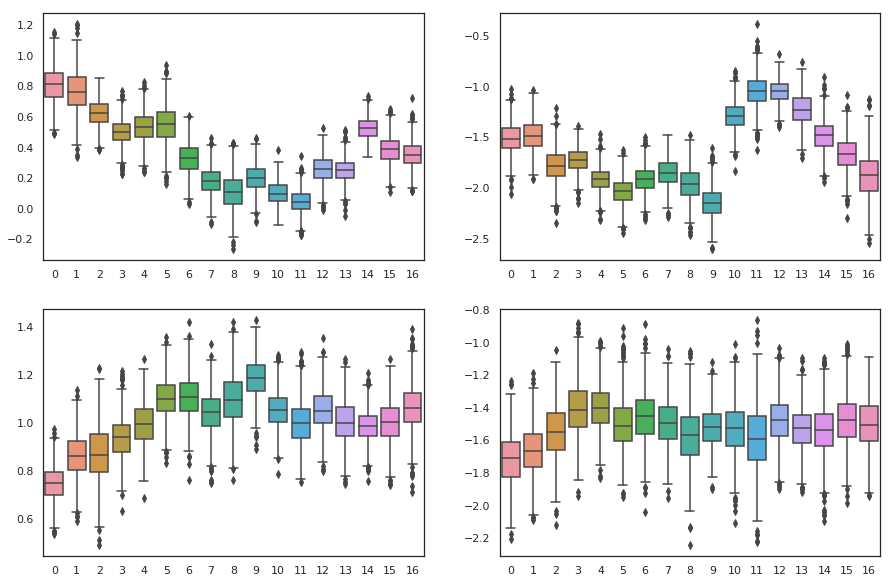

In [19]:
df_a = pd.DataFrame()
df_k = pd.DataFrame()
df_b = pd.DataFrame()
df_t = pd.DataFrame()
for n, sample in enumerate(posterior_samples_rl):
    m_g = sample[1]
    df_a[n] = m_g[r'$\alpha$']
    df_k[n] = m_g[r'$\kappa$']
    df_b[n] = m_g[r'$\beta$']
    df_t[n] = m_g[r'$\theta$']

fig, axes = plt.subplots(2, 2, figsize=(15,10));
sns.boxplot(data=df_a, ax=axes[0,0]);
sns.boxplot(data=df_k, ax=axes[0,1]);
sns.boxplot(data=df_b, ax=axes[1,0]);
sns.boxplot(data=df_t, ax=axes[1,1]);

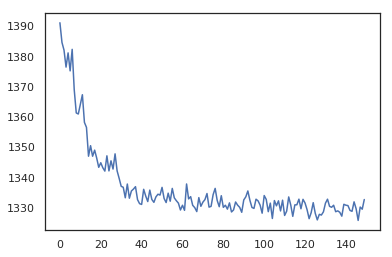

In [8]:
plt.figure()
plt.plot(rl_infer.loss[-150:]);

labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'$\theta$']
tp_df = rl_infer.sample_posterior(labels, n_samples=1000)

trans_pars_rl = tp_df[0].melt(id_vars='subject', var_name='parameter')

rl_par_names = ['alpha', 'kappa', 'beta', 'bias']
rl_df = rl_infer.formated_results(rl_par_names)

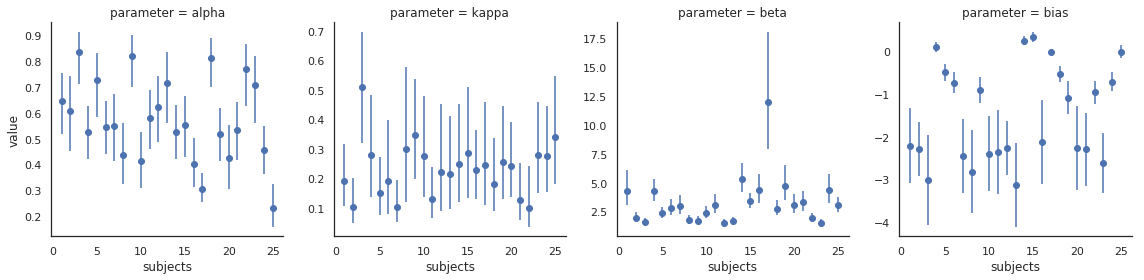

In [9]:
g = sns.FacetGrid(rl_df, col="parameter", height=4, sharey=False);
g = (g.map(errorplot, 'subjects', 'value', 'variables'));

In [6]:
# performe sequential parameter estimate and model selection
trials = 200

edhmm_agent_c1 = BayesTempRevLearn(runs=responses_c1.shape[-1], trials=trials)
edhmm_agent_c1.set_parameters()

edhmm_agent_c2 = BayesTempRevLearn(runs=responses_c2.shape[-1], trials=trials)
edhmm_agent_c2.set_parameters()

ps_edhmm_c1 = []
me_edhmm_c1 = []
ps_edhmm_c2 = []
me_edhmm_c2 = []
for i in range(1,17):
    T1 = 50*i
    T2 = T1 + trials
    mask = mask_c1[:, T1:T2].clone()
    offers = offers_c1[:, T1:T2].clone()
    outcomes = outcomes_c1[:, T1:T2].clone()
    responses = responses_c1[:, T1:T2].clone()
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    edhmm_infer = Horseshoe(edhmm_agent_c1, stimulus, responses, mask=mask)
    edhmm_infer.infer_posterior(iter_steps=200)
    
    labels = ['delta', 'rho', 'beta', 'lam', 'ph', 'pl']
    ps_edhmm_c1.append(edhmm_infer.sample_posterior(labels, n_samples=1000))
    
    me_edhmm_c1.append(edhmm_infer.get_log_evidence_per_subject(num_particles=200))
    
    mask = mask_c2[:, T1:T2].copy()
    offers = offers_c2[:, T1:T2].copy()
    outcomes = outcomes_c2[:, T1:T2].copy()
    responses = responses_c2[:, T1:T2].copy()
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    edhmm_infer = Horseshoe(edhmm_agent_c2, stimulus, responses, mask=mask)
    edhmm_infer.infer_posterior(iter_steps=200)
    
    labels = ['delta', 'rho', 'beta', 'lam', 'ph', 'pl']
    ps_edhmm_c2.append(edhmm_infer.sample_posterior(labels, n_samples=1000))
    
    me_edhmm_c2.append(edhmm_infer.get_log_evidence_per_subject(num_particles=200))

Mean ELBO 1106.80:   8%|▊         | 17/200 [03:23<36:31, 11.98s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:   9%|▉         | 18/200 [03:35<36:22, 11.99s/it] /mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  10%|▉         | 19/200 [03:46<35:44, 11.85s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  10%|█         | 20/200 [03:58<35:39, 11.89s/it]

KeyboardInterrupt: 

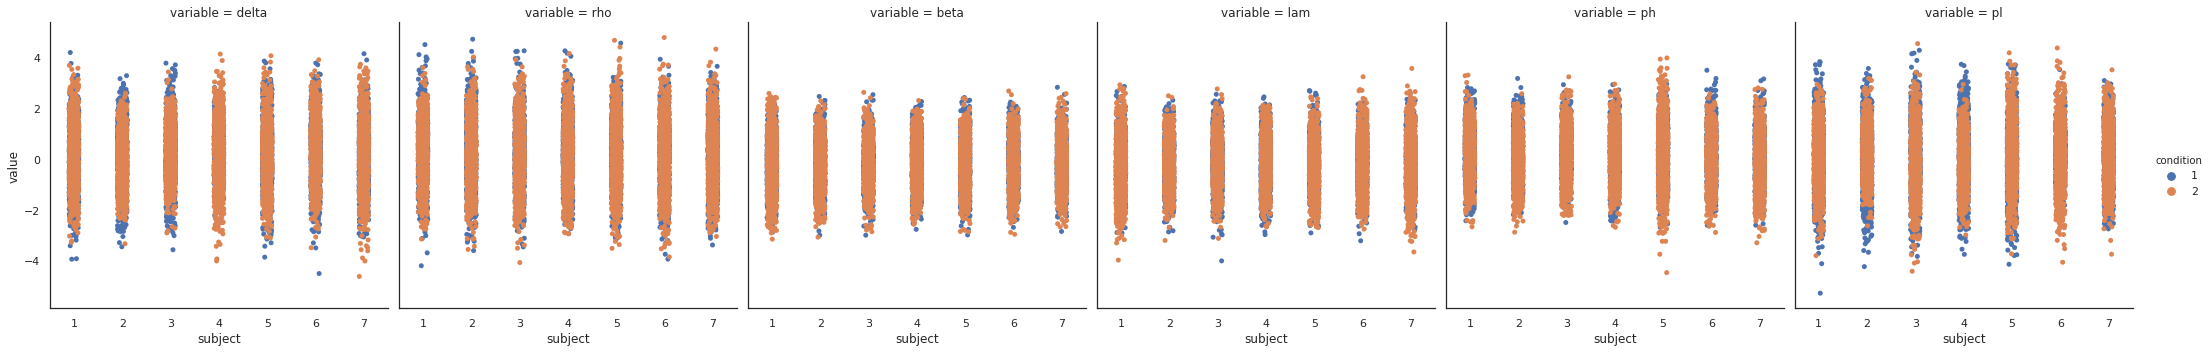

In [11]:
step = 1

data1 = pd.melt(ps_edhmm_c1[step][0], id_vars=['subject'], value_vars=['delta', 'rho', 'beta', 'lam', 'ph', 'pl'])
data1['condition'] = 1

data2 = pd.melt(ps_edhmm_c2[step][0], id_vars=['subject'], value_vars=['delta', 'rho', 'beta', 'lam', 'ph', 'pl'])
data2['condition'] = 2

data = data1.append(data2, ignore_index=True)

sns.catplot(x='subject', y='value', data=data, hue='condition', col='variable');

In [13]:
#Fit EDHMM agent
edhmm_agent = BayesTempRevLearn(runs=ns_irr, trials=trials)
edhmm_agent.set_parameters()

irr_mask[0, :50] = 0

edhmm_infer = Horseshoe(edhmm_agent, irr_stimulus, irr_res, mask=irr_mask)
edhmm_infer.infer_posterior(iter_steps=100)

Mean ELBO 782.30:  26%|██▌       | 26/100 [09:55<28:18, 22.96s/it] /mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  27%|██▋       | 27/100 [10:18<27:58, 23.00s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  28%|██▊       | 28/100 [10:41<27:40, 23.06s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  29%|██▉       | 29/100 [11:04<27:07, 22.92s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Mean ELBO    nan:  30%|███       | 30/100 [11:27<26:46, 22.95s/it]/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/s

Mean ELBO    nan: 100%|██████████| 100/100 [38:11<00:00, 22.83s/it]


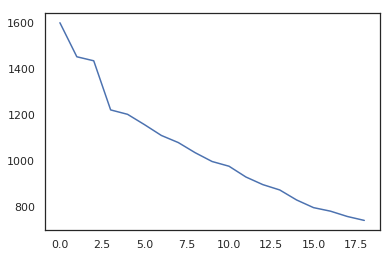

In [6]:
plt.figure()
plt.plot(edhmm_infer.loss[-150:]);

labels = [r'$\delta$', r'$\rho$', r'$\beta$', r'$\lambda$', r'ph', r'pl']
edhmm_tp_df = edhmm_infer.sample_posterior(labels, n_samples=1000)

trans_pars_rl = edhmm_tp_df[0].melt(id_vars='subject', var_name='parameter')

edhmm_par_names = ['delta', 'rho', 'beta', 'lam', 'ph', 'pl']
edhmm_df = edhmm_infer.formated_results(edhmm_par_names)

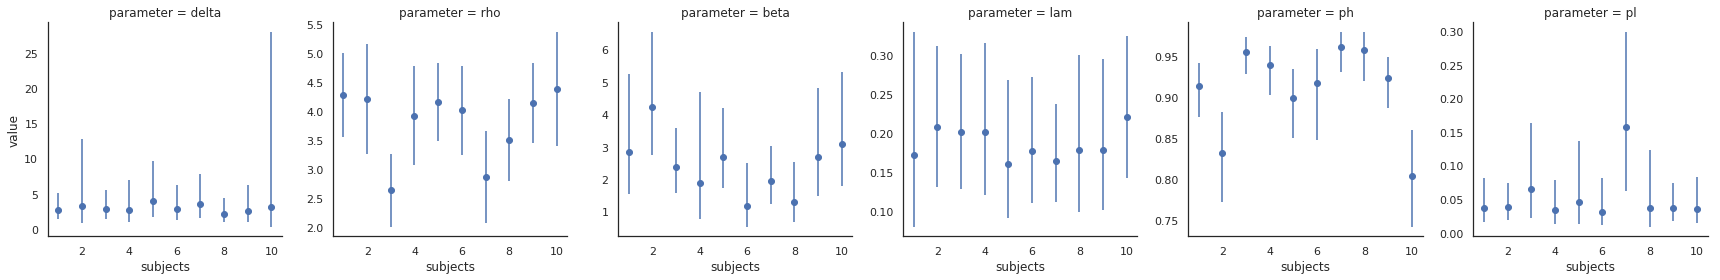

In [7]:
g = sns.FacetGrid(edhmm_df, col="parameter", height=4, sharey=False);
g = (g.map(errorplot, 'subjects', 'value', 'variables'));

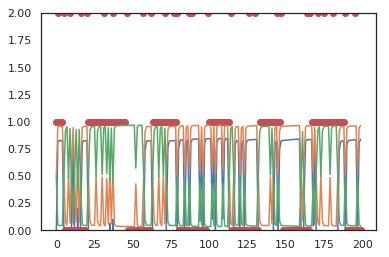

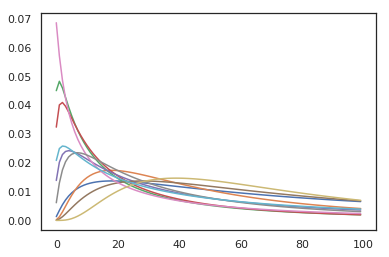

In [11]:
sub = 3
plt.plot(torch.stack(edhmm_agent.values)[:,sub,0].detach().numpy());
plt.plot(responses[0, :, sub].numpy(), 'ro');

#plt.plot(torch.stack(edhmm_agent.beliefs)[:-1].sum(-1)[:, sub, :].detach().numpy());
plt.ylim([0, 2])

plt.figure()
plt.plot(edhmm_agent.pd.detach().numpy().T);

In [12]:
em_edhmm = edhmm_infer.get_log_evidence_per_subject(num_particles = 200)
print(em_edhmm)

tensor([ -48.8127,  -32.6543,  -81.1509,  -64.3744,  -70.2451,  -95.6259,
         -99.6841, -102.6976,  -55.5495,  -73.4289])


In [20]:
torch.arange(nsub)[(responses_all == 2)[0].sum(-2) > 10]


tensor([ 0,  3,  5,  6,  7, 10, 13, 15, 16, 18, 19, 20, 23, 24, 25])

In [10]:

edhmm_agent = BayesTempRevLearn(runs=nsub, trials=trials)
edhmm_agent.set_parameters()

posterior_samples_edhmm = []
model_evidences_edhmm = []
for i in range(20):
    T1 = 50*i
    T2 = 50*i + 200
    mask = mask_all[:, T1:T2]
    offers = offers_all[:, T1:T2]
    outcomes = outcomes_all[:, T1:T2]
    responses = responses_all[:, T1:T2]
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask = mask[:, :50] = 0
    edhmm_infer = Horseshoe(edhmm_agent, stimulus, responses, mask=mask)
    edhmm_infer.infer_posterior(iter_steps=200)
    
    labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'$\theta$']
    posterior_samples_edhmm.append(ed_hmm_infer.sample_posterior(labels, n_samples=1000))
    
    model_evidences_edhmm.append(edhmm_infer.get_log_evidence_per_subject(num_particles = 200))
    